In [30]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf, coint, acovf, ccovf

In [31]:
parcel = 1

In [32]:
# Import dataset
df = pd.read_csv('data/parcel_{}_combined.csv'.format(parcel), delimiter=',')
df.head()

# Convert fecha column to datetime
df['date'] = pd.to_datetime(df['date'])

# Make date as index
df = df.set_index('date')

In [33]:
# Info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 591 entries, 2022-01-10 to 2023-08-23
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   eto                           585 non-null    float64
 1   ndvi_mean                     237 non-null    float64
 2   ndwi_mean                     237 non-null    float64
 3   ndmi_mean                     237 non-null    float64
 4   gndvi_mean                    237 non-null    float64
 5   evi_mean                      237 non-null    float64
 6   evi2_mean                     237 non-null    float64
 7   savi_mean                     237 non-null    float64
 8   lst_mean                      512 non-null    float64
 9   sensor_temperatura_90cm_mean  281 non-null    float64
 10  sensor_humedad_90cm_mean      281 non-null    float64
 11  sensor_salinidad_90cm_mean    281 non-null    float64
 12  irrigation_mm                 591 non-null   

In [34]:
# Check for outliers
df.describe()

,eto,ndvi_mean,ndwi_mean,ndmi_mean,gndvi_mean,evi_mean,evi2_mean,savi_mean,lst_mean,sensor_temperatura_90cm_mean,sensor_humedad_90cm_mean,sensor_salinidad_90cm_mean,irrigation_mm
count,585.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,512.000000,281.000000,281.000000,281.000000,591.000000
mean,3.405586,0.304800,-0.355412,0.060917,0.355412,0.246960,0.221439,0.218523,18.761271,20.012014,20.012014,20.012014,1.596965
std,1.909789,0.151813,0.176022,0.131365,0.176022,0.186860,0.112117,0.109469,8.671761,5.078759,5.078759,5.078759,0.920429
min,0.511429,-0.092726,-0.603984,-0.129408,-0.128391,-1.008412,-0.166043,-0.115580,-2.065000,12.064583,12.064583,12.064583,0.290320
25%,1.465714,0.237704,-0.488744,-0.025067,0.289348,0.179134,0.165270,0.166219,11.830000,16.315833,16.315833,16.315833,0.621427
50%,3.445714,0.333800,-0.417199,0.044452,0.417199,0.265899,0.239234,0.234249,18.695000,20.094792,20.094792,20.094792,1.550000
75%,5.430000,0.424006,-0.289348,0.096106,0.488744,0.321992,0.319431,0.315064,26.749000,22.173333,22.173333,22.173333,2.522587
max,6.214286,0.513242,0.128391,0.621039,0.603984,1.077643,0.384136,0.371622,36.688000,29.099583,29.099583,29.099583,2.812907


In [35]:
# Check for missing values
df.isna().sum()

eto                               6
ndvi_mean                       354
ndwi_mean                       354
ndmi_mean                       354
gndvi_mean                      354
evi_mean                        354
evi2_mean                       354
savi_mean                       354
lst_mean                         79
sensor_temperatura_90cm_mean    310
sensor_humedad_90cm_mean        310
sensor_salinidad_90cm_mean      310
irrigation_mm                     0
dtype: int64

In [36]:
# Check for duplicated values
df.duplicated().sum()

0

<Axes: >

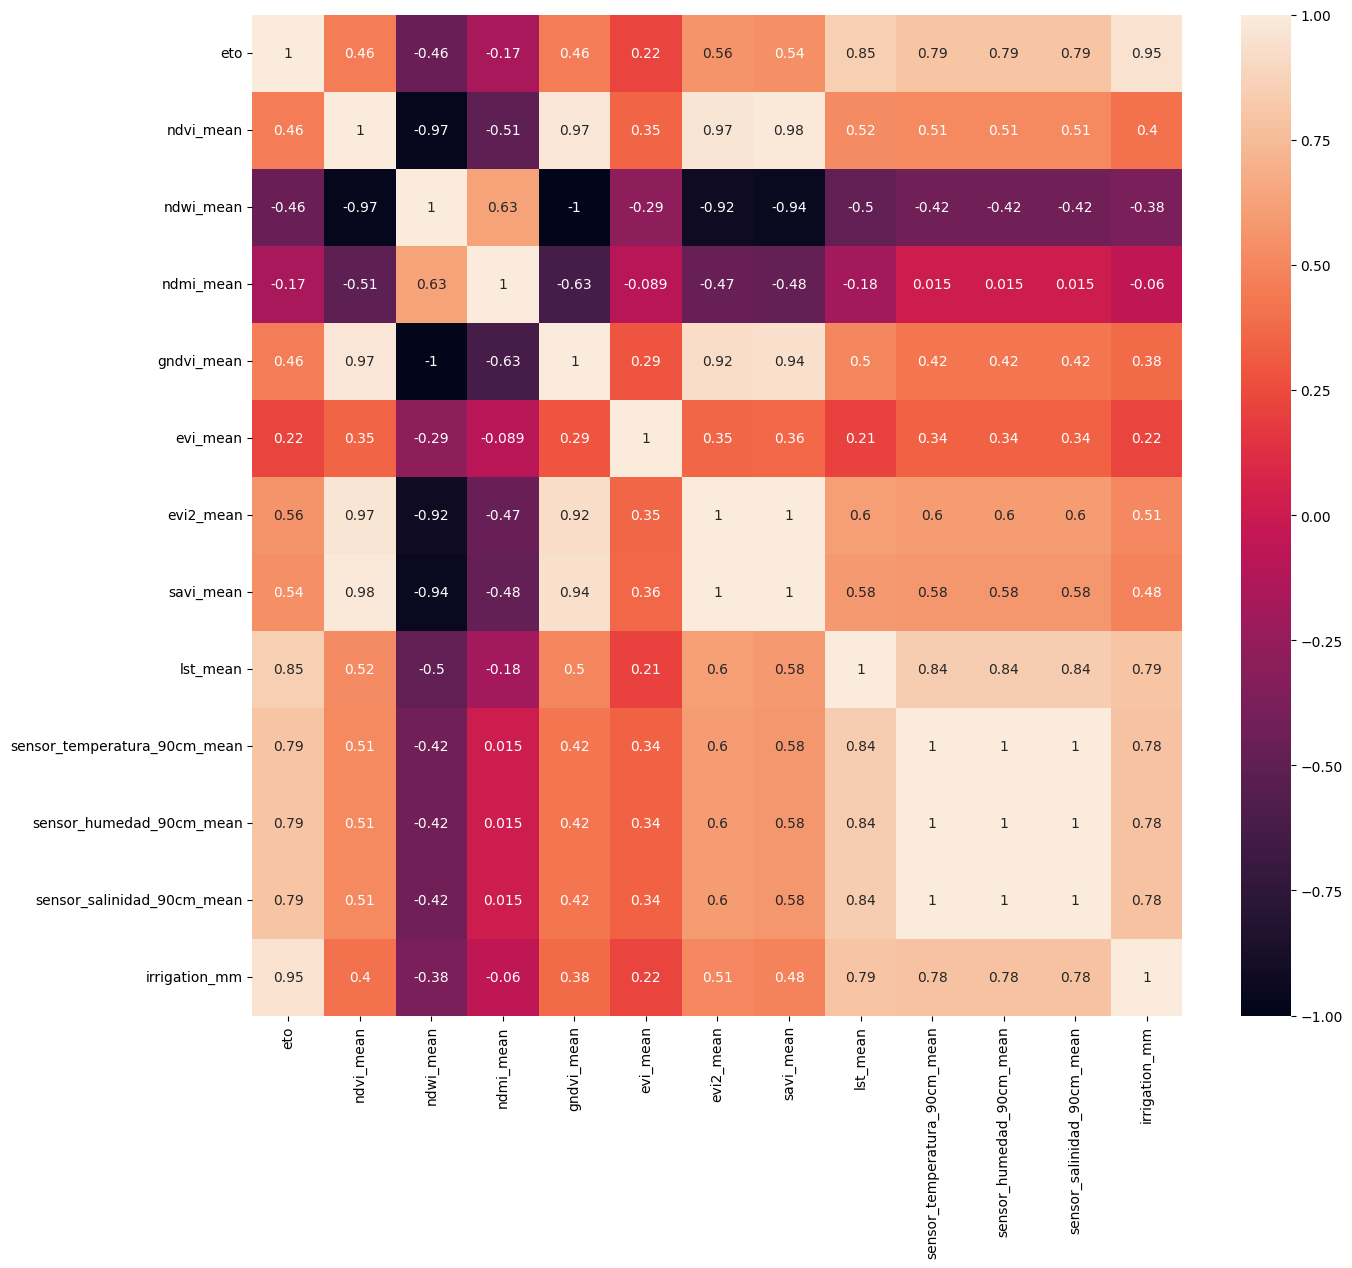

In [37]:
# Plot the correlation matrix
plt.figure(figsize=(15, 13))
sns.heatmap(df.corr(), annot=True)

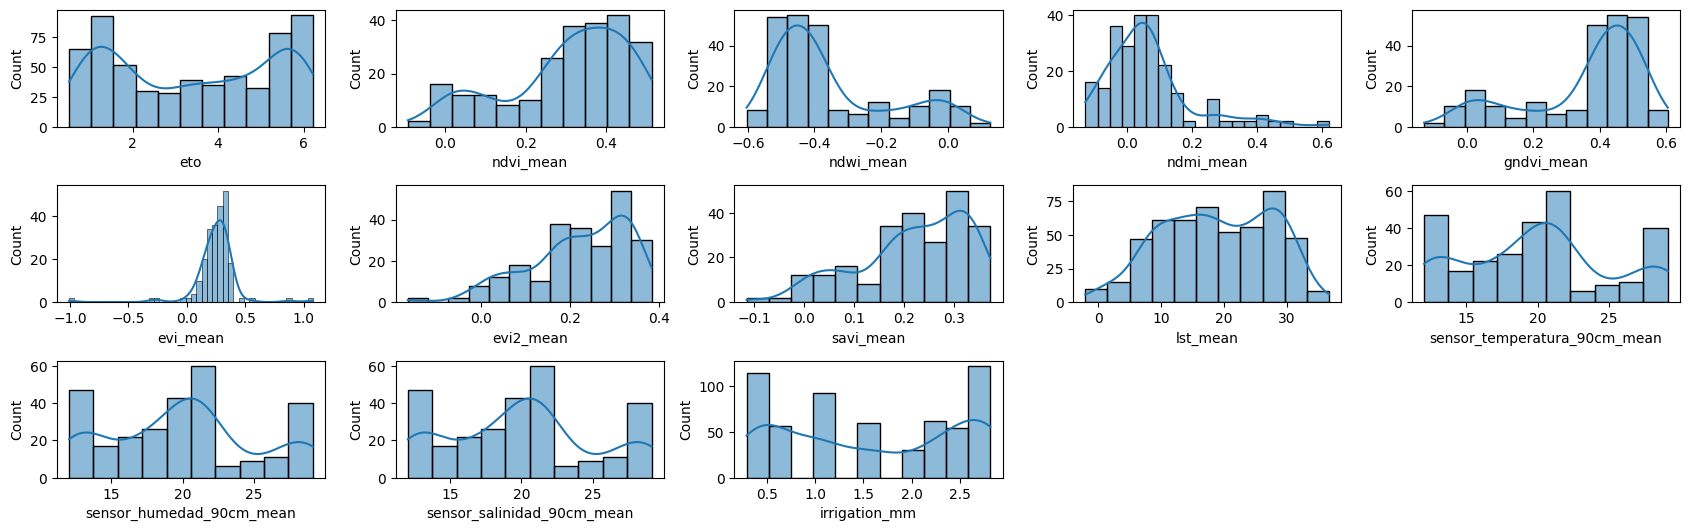

In [38]:
# Plot the distribution of the target variable
plt.figure(figsize=(17, 12))
# distribution plot for every column (34 or so in total)
for i, col in enumerate(df.columns):
    plt.subplot(7, 5, i+1)
    sns.histplot(df[col], kde=True)
    plt.tight_layout()

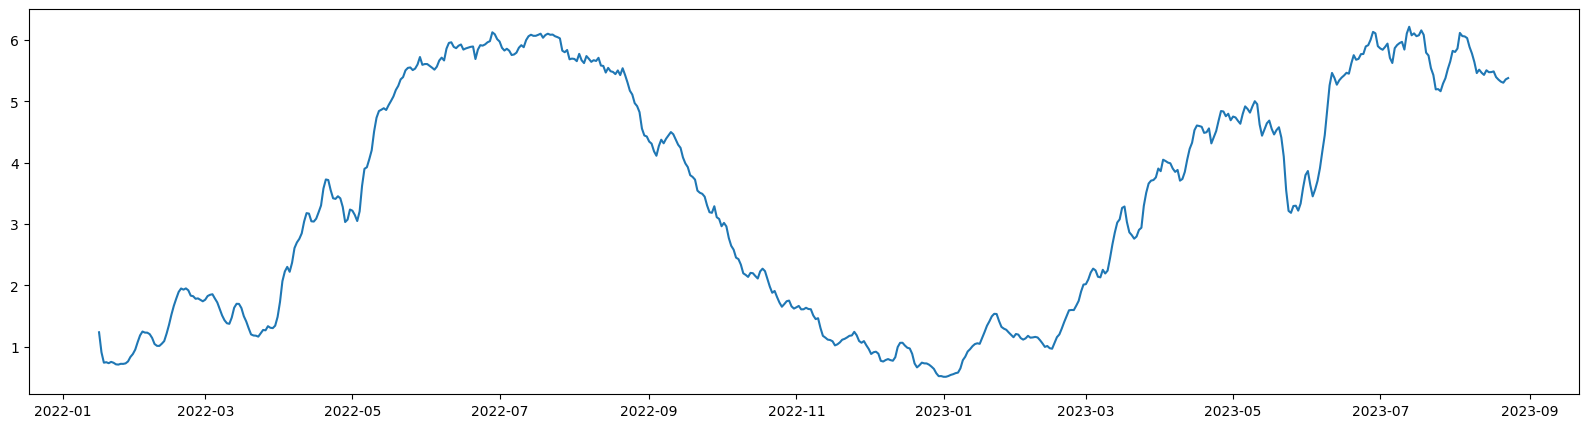

In [39]:
# Plot the target variable
plt.figure(figsize=(20, 5))
plt.plot(df.index, df['eto'])


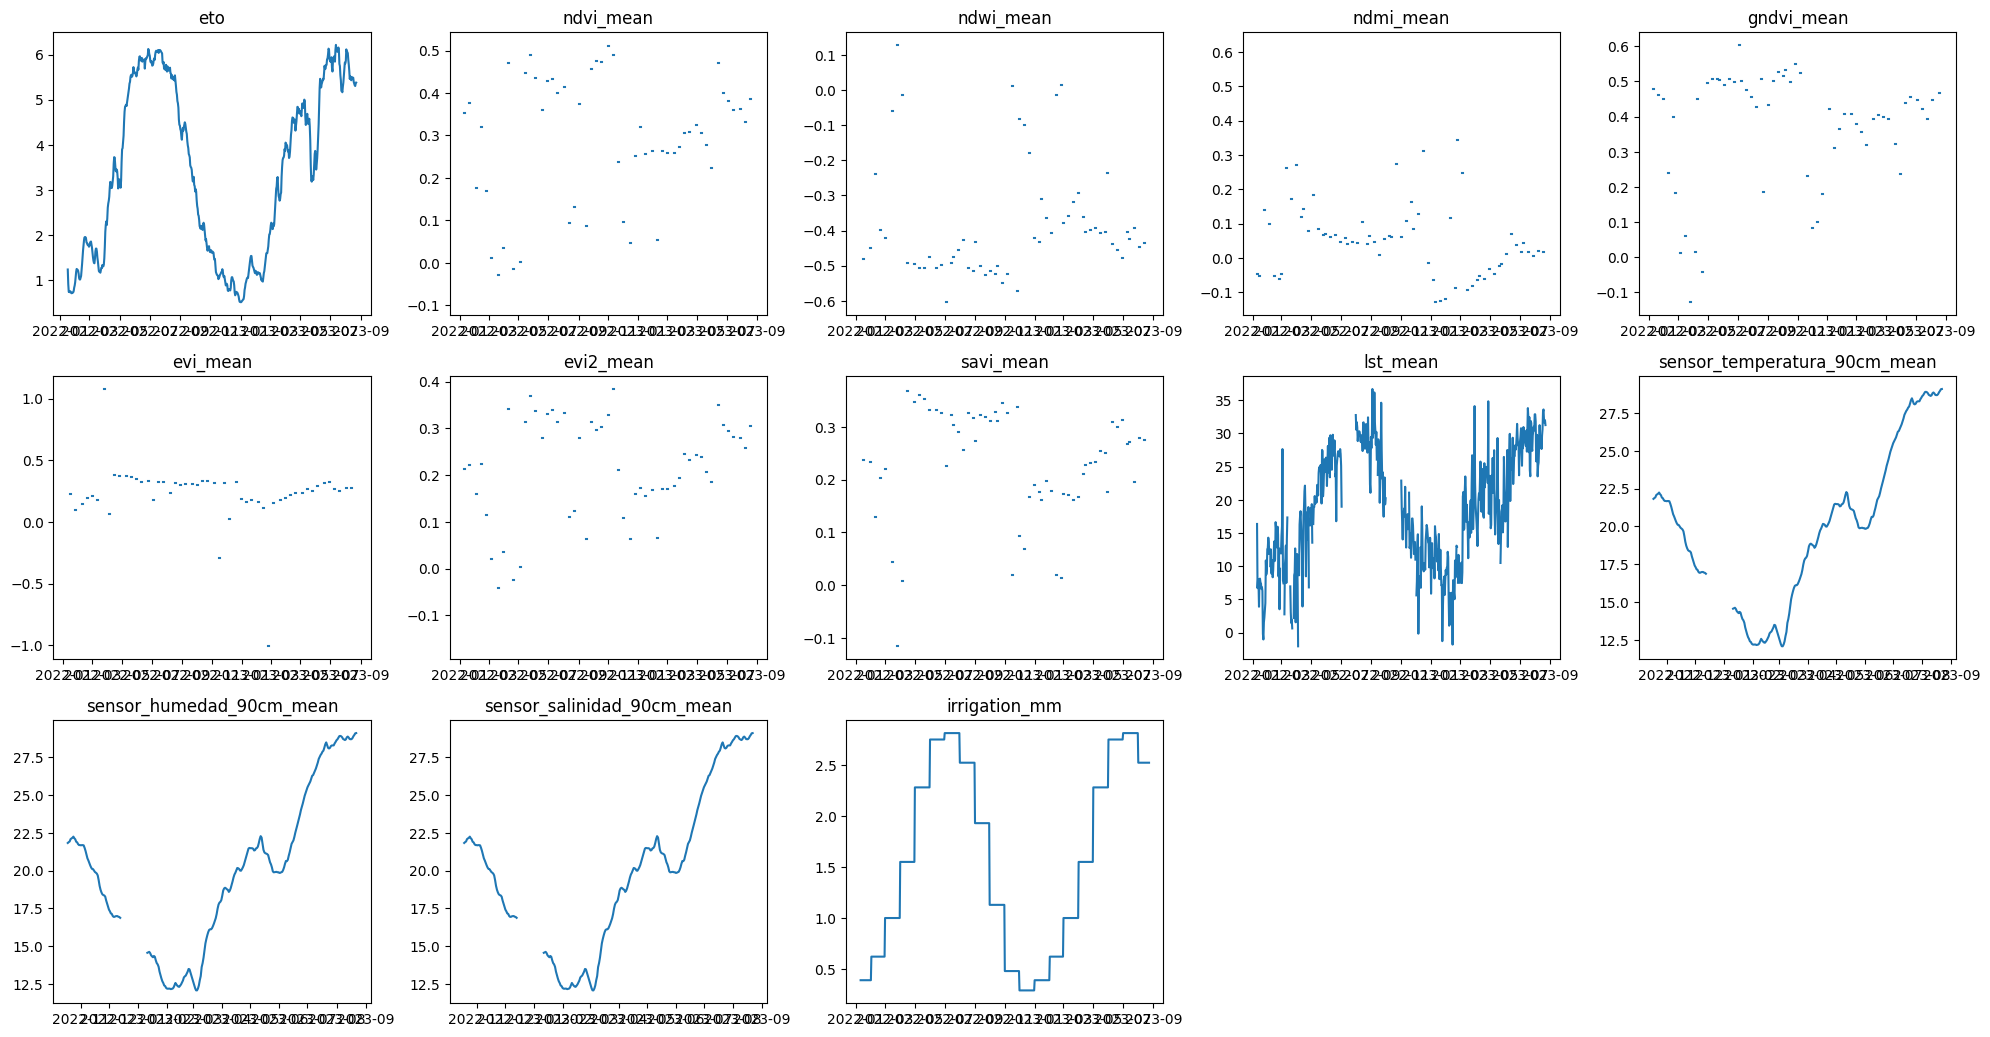

In [40]:
# Plot all variables one after the other in separate line plots, sharing same x-axis
plt.figure(figsize=(20, 24))
for i, col in enumerate(df.columns):
    plt.subplot(7, 5, i+1)
    plt.plot(df.index, df[col])
    plt.title(col)
    plt.tight_layout()

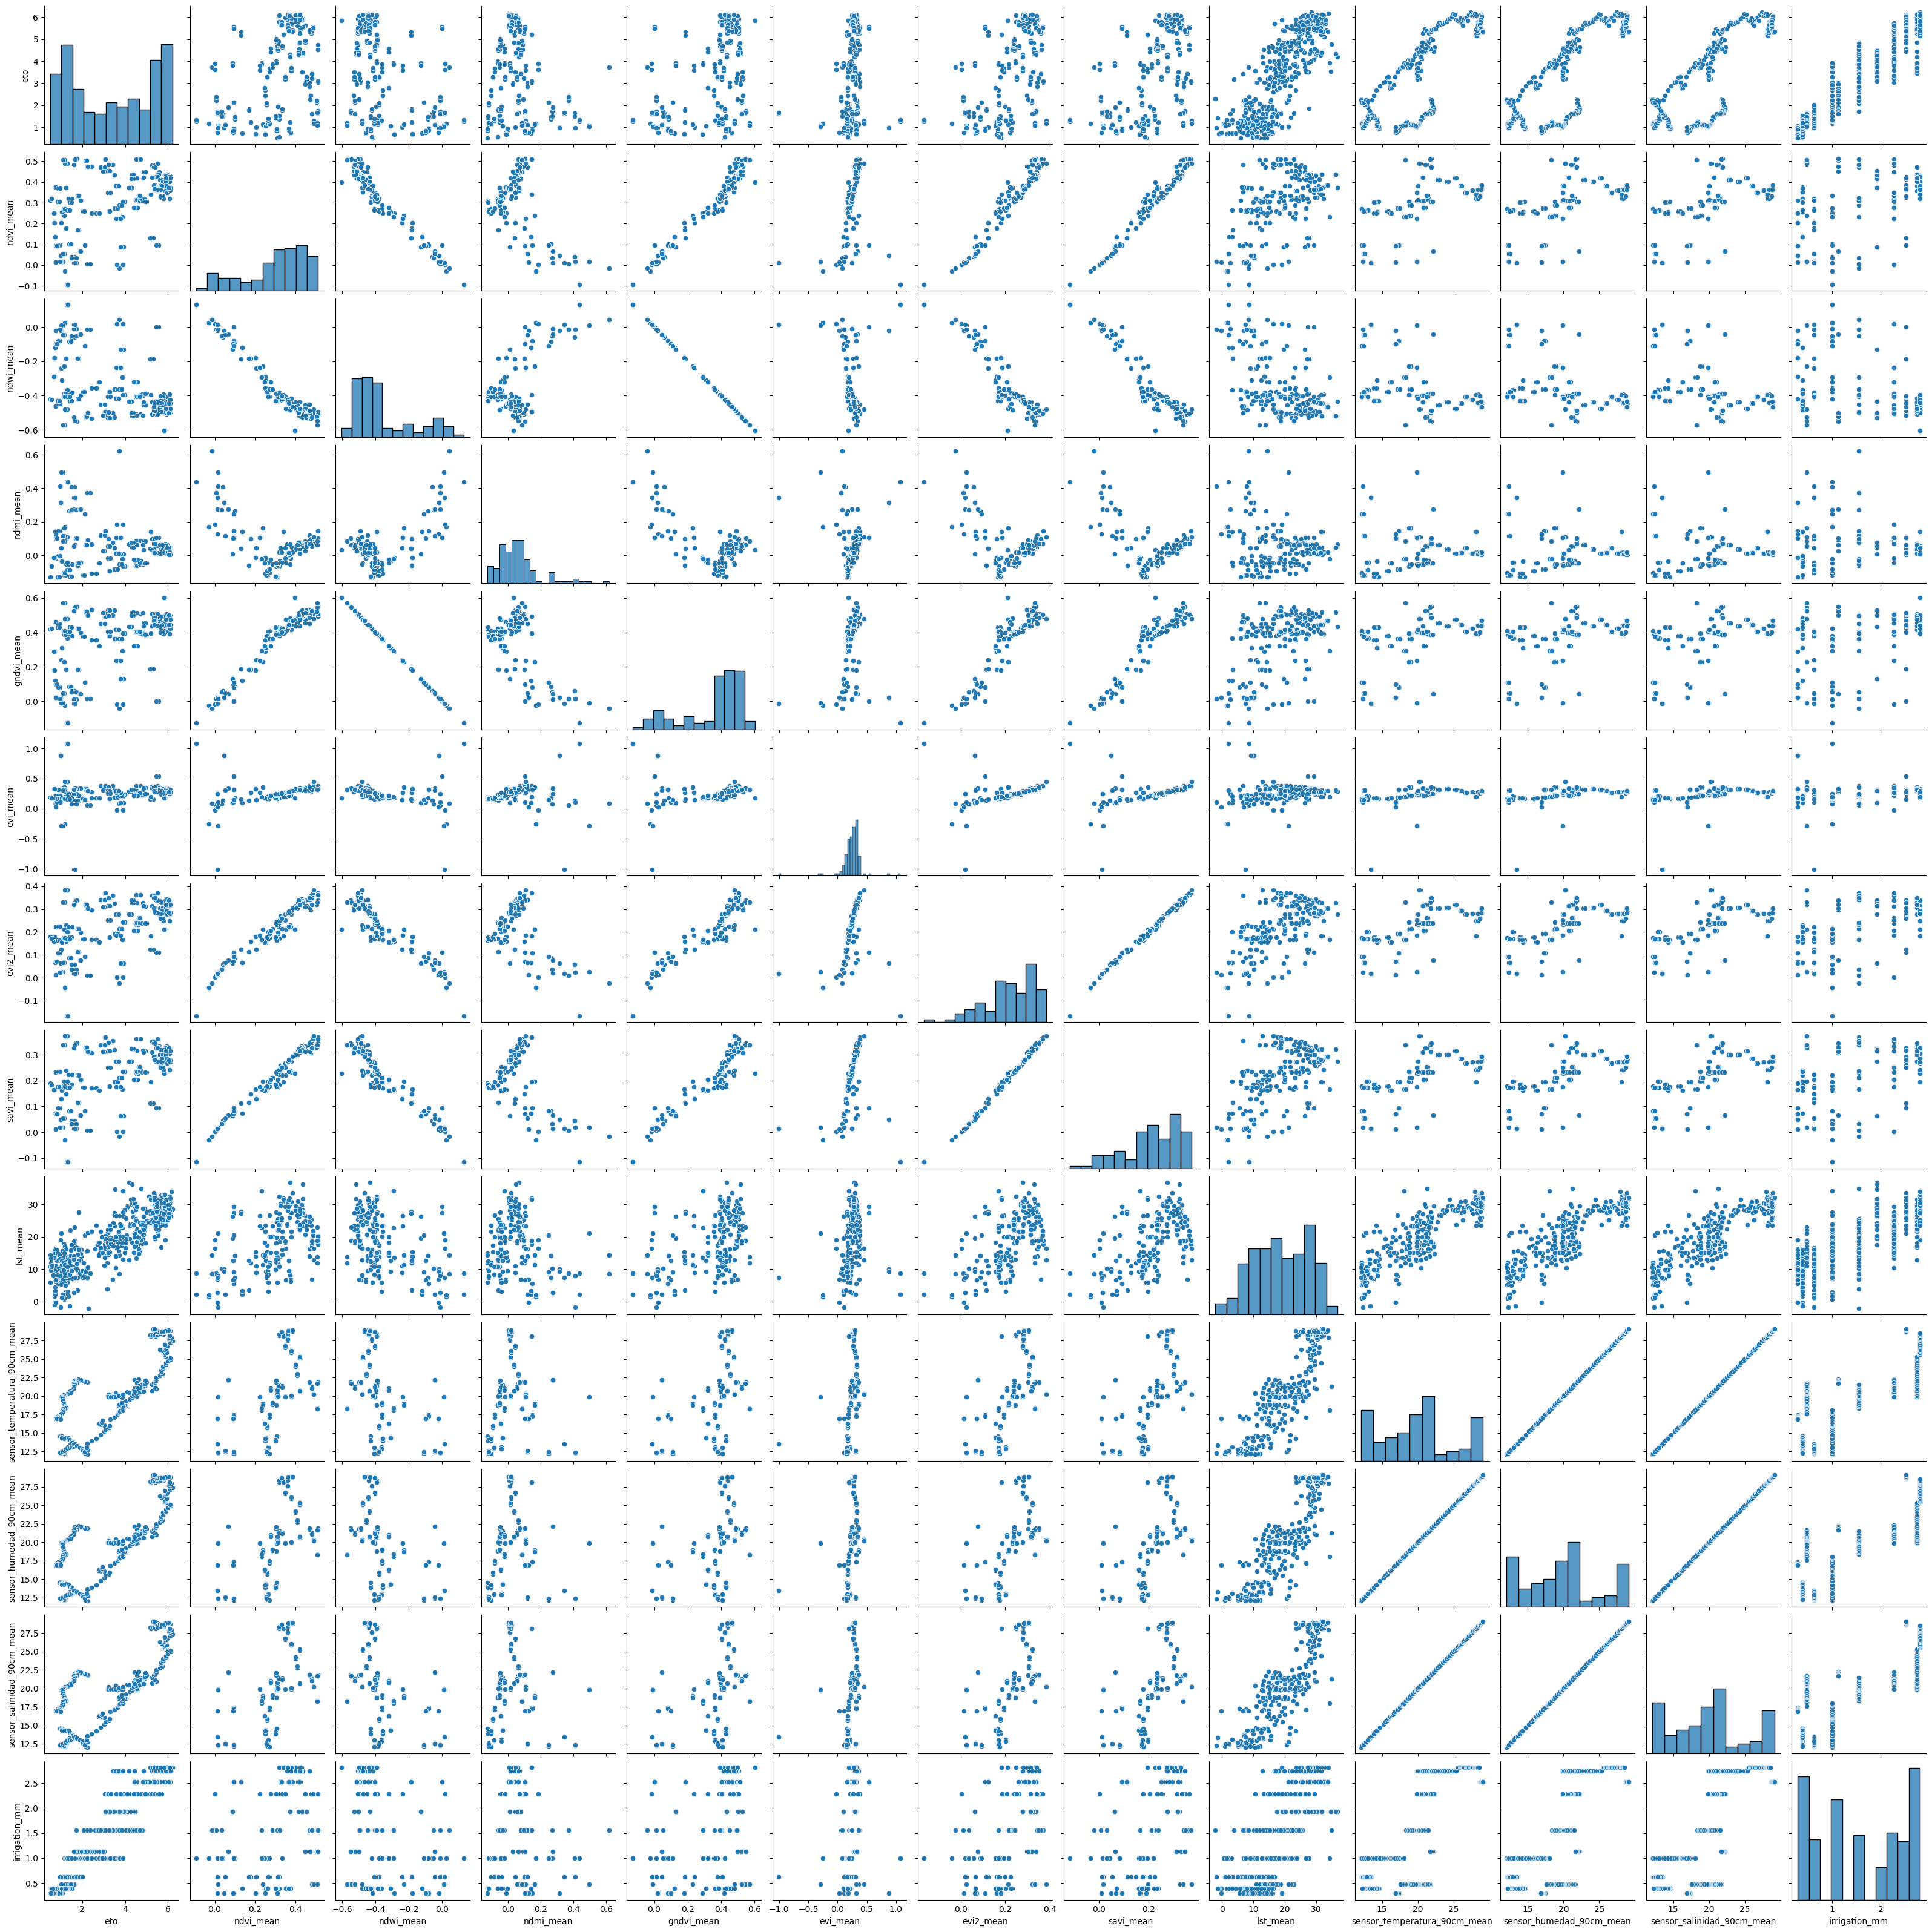

In [41]:
# Plot all variables paired
sns.pairplot(df)

In [42]:
# prepare variables for heatmap
df['month'] = df.index.month
df['year'] = df.index.year
df['day'] = df.index.day
df['hour'] = df.index.hour
df['dayName'] = df.index.day_name()
df['weekday'] = df.index.weekday
df['week'] = df.index.isocalendar().week
df['weekend'] = df.index.weekday // 5 == 1

# order weekdays
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df.dayName = pd.Categorical(df.dayName, categories=weekdays, ordered=True)


<Axes: xlabel='day', ylabel='month'>

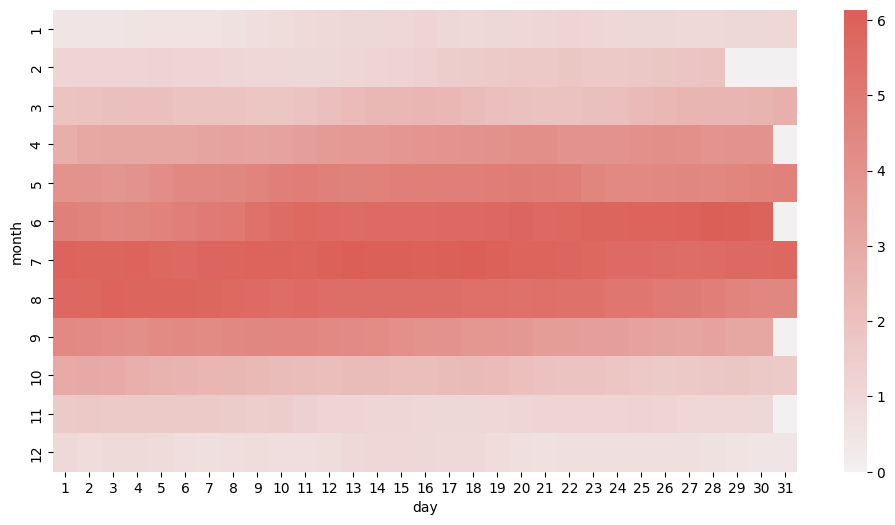

In [43]:
plt.figure(figsize=(12, 6))

# Plot the heatmap for eto
sns.heatmap(pd.pivot_table(df,
              values="eto",
              index=["month"],
              columns=["day"],
              aggfunc=lambda x: x.mean(),
              fill_value=0,
            ), 
            cmap=sns.light_palette("#db5f57", as_cmap=True))

<Axes: xlabel='day', ylabel='month'>

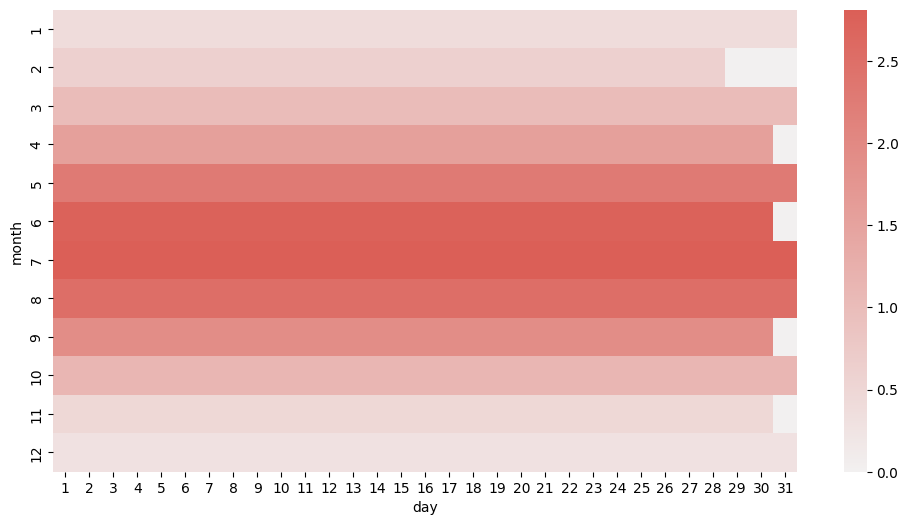

In [44]:
plt.figure(figsize=(12, 6))

# Plot the heatmap for irrigation in mm
sns.heatmap(pd.pivot_table(df,
              values="irrigation_mm",
              index=["month"],
              columns=["day"],
              aggfunc=lambda x: x.mean(),
              fill_value=0,
            ), 
            cmap=sns.light_palette("#db5f57", as_cmap=True))